# Module

In [1]:
import numpy as np
import pandas as pd
import warnings
import gc
from tqdm import tqdm_notebook as tqdm
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.metrics import roc_auc_score
warnings.filterwarnings("ignore")
gc.enable()

In [2]:
pd.set_option('max_rows', 500)
pd.set_option('max_colwidth', 500)
pd.set_option('max_columns', 500)

# Load Data

In [3]:
train_raw = pd.read_csv('./data/train.csv')
test_raw = pd.read_csv('./data/test.csv')
train_raw.shape, test_raw.shape

((200000, 202), (200000, 201))

In [4]:
# del train, test, data, clf
# gc.collect()

In [68]:
train = train_raw.copy()
test = test_raw.copy()

In [69]:
col_list = train.columns[2:]

In [70]:
train_0 = train[train.target == 0]
train_1 = train[train.target == 1]

In [71]:
pb_idx = np.load('./data_temp/public_LB.npy')
pv_idx = np.load('./data_temp/private_LB.npy')

In [72]:
test_pb = test.iloc[pb_idx].sort_index().copy()
test_pv = test.iloc[pv_idx].sort_index().copy()

test_real = test_pb.append(test_pv)

In [73]:
data = train.append(test_real)[['ID_code', 'target'] + col_list.tolist()]

In [74]:
for col in col_list:
    data[col] = (data[col] - data[col].mean()) / data[col].std()

In [75]:
for col in tqdm(col_list):
    data[col] = data[col].map(data[col].value_counts().to_dict())

# Extract Unique Value in All Data

In [11]:
unique_df = data[['ID_code']]
con_df = data[['ID_code']]

In [12]:
for col in tqdm(col_list):
    unique_df[col] = data[col].map(((data[col].value_counts() == 1) * 1).to_dict())
    con_df[col] = data[col].map((~(data[col].value_counts() == 1) * 1).to_dict())

In [13]:
for col in tqdm(col_list):
    data[col + '_unique'] = np.around(data[col] * unique_df[col], 4)
    data[col + '_con'] = np.around(data[col] * con_df[col], 4)

In [14]:
for col in tqdm(col_list):
    data.loc[data[col + '_unique']==0, col + '_unique'] = np.nan
    data.loc[data[col + '_con']==0, col + '_con'] = np.nan

In [15]:
for col in tqdm(col_list):
    data[col + '_con_multi_counts'] = data[col + '_con'] * data[col].map(data[col].value_counts().to_dict())

# Model

In [77]:
train = data[~data.target.isna()].sort_index()
test = data[data.target.isna()].sort_index()

In [292]:
train['pred'] = pd.read_csv('./data/train_lgb_KYM_numleaves2_con_conaround_aug5_cv_0.9254813283451607.csv')['0'].values
test['pred'] = pd.read_csv('./data/test_lgb_KYM_numleaves2_con_conaround_aug5_cv_0.9254813283451607.csv')['0'].values

In [78]:
target = train['target']

In [79]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.335,
    'boost_from_average': False,
    'boost': 'gbdt',
    'feature_fraction_seed': 47,
    'feature_fraction': 0.041,
    'learning_rate': 0.01,
    'max_depth': -1,
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 2,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': -1,
    'num_threads': 8
}

In [80]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))
feature_importance = pd.DataFrame()

train_columns = [c for c in train.columns if c not in ['ID_code', 'target']]

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, target.values)):    
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][train_columns], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx][train_columns], label=target.iloc[val_idx])

    num_round = 500000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=5000, early_stopping_rounds = 3500)
    oof_lgb[val_idx] = clf.predict(train.iloc[val_idx][train_columns], num_iteration=clf.best_iteration)
    predictions_lgb += clf.predict(test[train_columns], num_iteration=clf.best_iteration) / folds.n_splits

    fold_importance = pd.DataFrame()
    fold_importance["Feature"] = train_columns
    fold_importance["importance"] = clf.feature_importance()
    fold_importance["fold"] = fold_ + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
    print("CV score: {:<8.5f}".format(roc_auc_score(target.values[val_idx], oof_lgb[val_idx])))
            
print("CV score: {:<8.5f}".format(roc_auc_score(target.values, oof_lgb)))

fold n°0
Training until validation scores don't improve for 3500 rounds.
[5000]	training's auc: 0.670095	valid_1's auc: 0.655963
[10000]	training's auc: 0.679171	valid_1's auc: 0.661659


KeyboardInterrupt: 

In [22]:
pd.read_csv('./data_temp/test_92274.csv')

,ID_code,target
0,test_7,0.066608
1,test_17,0.018760
2,test_18,0.054083
3,test_21,0.040384
4,test_24,0.007588
5,test_29,0.016276
6,test_48,0.004924
7,test_63,0.037557
8,test_68,0.004899
9,test_69,0.000781


In [26]:
oof_temp = train[['ID_code']]
oof_temp['target'] = oof_lgb

te_temp = test[['ID_code']]
te_temp['target'] = predictions_lgb

oof_temp.to_csv('./data_temp/train_92274.csv', index=False)
te_temp.to_csv('./data_temp/test_92274.csv', index=False)

del oof_temp, te_temp
gc.collect()

0

In [30]:
oof_temp = train[['ID_code', 'target']]
oof_temp['pred'] = oof_lgb
oof_temp.to_csv('./data_temp/new_bbiggu_magic2.csv', index=False)

del oof_temp
gc.collect()

0

# oof Data

In [16]:
oof = pd.read_csv('./data_temp/new_bbiggu_magic2.csv')

bbiggu_0_id_code = oof[(oof.target == 0) & (oof.pred > 0.1)].ID_code
bbiggu_1_id_code = oof[(oof.target == 1) & (oof.pred < 0.1)].ID_code
normal_0_id_code = oof[(oof.target == 0) & (oof.pred < 0.1)].ID_code
normal_1_id_code = oof[(oof.target == 1) & (oof.pred > 0.1)].ID_code

In [17]:
# normal_0_tr = data[data.ID_code.isin(normal_0_id_code)][:100000].copy()
# normal_0_val = data[data.ID_code.isin(normal_0_id_code)][100000:].copy()
normal_0 = data[data.ID_code.isin(normal_0_id_code)].copy()
normal_1 = data[data.ID_code.isin(normal_1_id_code)].copy()
bbiggu_0 = data[data.ID_code.isin(bbiggu_0_id_code)].copy()
bbiggu_1 = data[data.ID_code.isin(bbiggu_1_id_code)].copy()

In [53]:
normal_0_tr

Int64Index([     0,      2,      3,      4,      5,      7,      8,      9,
                10,     11,
            ...
            199988, 199989, 199991, 199992, 199993, 199995, 199996, 199997,
            199998, 199999],
           dtype='int64', length=151636)

In [83]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.335,
    'boost_from_average': False,
    'boost': 'gbdt',
    'feature_fraction_seed': 47,
    'feature_fraction': 0.041,
    'learning_rate': 0.01,
    'max_depth': -1,
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 2,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': 1,
    'num_threads': 8
}

In [96]:
result = normal_0_val.append(bbiggu_1)[['ID_code', 'target']]

In [97]:
for i in tqdm(range(100)):
    print(i)
    
    tr_0 = normal_0_tr.iloc[np.random.permutation(list(range(normal_0_tr.shape[0])))[:16923]]
    tr_1 = normal_1

    train = tr_0.append(tr_1).sort_index()
    target = train.target

    folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    train_columns = [c for c in train.columns if c not in ['ID_code', 'target']]

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, target.values)):
        trn_data = lgb.Dataset(train.iloc[trn_idx][train_columns], label=target.iloc[trn_idx])
        val_data = lgb.Dataset(train.iloc[val_idx][train_columns], label=target.iloc[val_idx])

        num_round = 15000
        clf_new = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=10000, early_stopping_rounds = 200)
        break
        
    result['fold_' + str(i)] = clf_new.predict(normal_0_val.append(bbiggu_1)[train_columns])

0
Training until validation scores don't improve for 200 rounds.
[10000]	training's auc: 0.989905	valid_1's auc: 0.982247
Did not meet early stopping. Best iteration is:
[14999]	training's auc: 0.995561	valid_1's auc: 0.989399
1
Training until validation scores don't improve for 200 rounds.
[10000]	training's auc: 0.989106	valid_1's auc: 0.98425
Did not meet early stopping. Best iteration is:
[14997]	training's auc: 0.995149	valid_1's auc: 0.99072
2
Training until validation scores don't improve for 200 rounds.
[10000]	training's auc: 0.989196	valid_1's auc: 0.985066
Did not meet early stopping. Best iteration is:
[15000]	training's auc: 0.995052	valid_1's auc: 0.991528
3
Training until validation scores don't improve for 200 rounds.
[10000]	training's auc: 0.989327	valid_1's auc: 0.984353
Did not meet early stopping. Best iteration is:
[14996]	training's auc: 0.995112	valid_1's auc: 0.991154
4
Training until validation scores don't improve for 200 rounds.
[10000]	training's auc: 0.989

KeyboardInterrupt: 

In [98]:
result

,ID_code,target,fold_0,fold_1,fold_2,fold_3,fold_4,fold_5,fold_6,fold_7,fold_8,fold_9,fold_10,fold_11,fold_12,fold_13,fold_14,fold_15,fold_16,fold_17,fold_18,fold_19,fold_20,fold_21,fold_22,fold_23,fold_24,fold_25,fold_26,fold_27,fold_28,fold_29,fold_30,fold_31,fold_32
131693,train_131693,0.0,0.120675,0.090807,0.107714,0.086557,0.115839,0.108100,0.109976,0.097057,0.094727,0.085231,0.088303,0.102138,0.105108,0.096123,0.071436,0.114130,0.083848,0.111694,0.116422,0.097018,0.132394,0.095114,0.094423,0.128700,0.116063,0.097637,0.108006,0.100083,0.092149,0.109811,0.119294,0.119692,0.103260
131694,train_131694,0.0,0.114390,0.116643,0.169975,0.132976,0.118237,0.157022,0.157295,0.133667,0.126253,0.137206,0.130378,0.147752,0.121414,0.122476,0.111730,0.169618,0.139668,0.127939,0.104319,0.115983,0.147685,0.154078,0.147839,0.115306,0.113831,0.161030,0.133910,0.151963,0.172976,0.126631,0.149003,0.119875,0.127360
131695,train_131695,0.0,0.486819,0.497126,0.521941,0.514030,0.496947,0.530429,0.490779,0.525185,0.535626,0.523270,0.440015,0.532527,0.490755,0.565434,0.540621,0.523819,0.523128,0.490207,0.435361,0.437362,0.560337,0.527873,0.518044,0.505956,0.451384,0.559226,0.595693,0.540063,0.575409,0.505814,0.500842,0.558745,0.479995
131696,train_131696,0.0,0.328583,0.359964,0.301610,0.264585,0.392908,0.336332,0.342434,0.268084,0.301987,0.298607,0.289859,0.324627,0.377491,0.329210,0.305833,0.274209,0.281726,0.340585,0.305400,0.313230,0.346564,0.221819,0.250490,0.335942,0.353142,0.303998,0.337490,0.292497,0.268100,0.309137,0.321608,0.277008,0.287383
131697,train_131697,0.0,0.259596,0.336613,0.267499,0.302831,0.298277,0.238419,0.298846,0.334293,0.310486,0.296828,0.314946,0.311170,0.269282,0.302175,0.354199,0.300018,0.296380,0.367447,0.276688,0.366686,0.286830,0.323569,0.269572,0.350291,0.233929,0.312112,0.283681,0.324659,0.325862,0.345283,0.250199,0.323660,0.289812
131700,train_131700,0.0,0.369381,0.325850,0.379042,0.300465,0.313476,0.316763,0.345414,0.324583,0.321657,0.351075,0.340246,0.351473,0.331752,0.341940,0.339326,0.346083,0.321554,0.333158,0.365276,0.327382,0.373012,0.343056,0.310067,0.326994,0.329603,0.385870,0.380849,0.314730,0.355673,0.322140,0.372873,0.352537,0.358696
131701,train_131701,0.0,0.063134,0.065167,0.077060,0.062812,0.080244,0.076406,0.078642,0.071204,0.059264,0.066599,0.074796,0.083441,0.063793,0.074952,0.075675,0.068928,0.067616,0.061671,0.064805,0.073880,0.091567,0.069881,0.068109,0.056662,0.071026,0.066416,0.060446,0.096636,0.057793,0.059762,0.077370,0.066569,0.067477
131702,train_131702,0.0,0.055606,0.049343,0.055927,0.034376,0.048890,0.060655,0.053705,0.054040,0.057241,0.055472,0.052778,0.050640,0.047014,0.051009,0.060742,0.062858,0.053184,0.051103,0.056893,0.047439,0.051554,0.060349,0.045228,0.054582,0.059869,0.058813,0.054233,0.043011,0.058609,0.061821,0.061683,0.052807,0.055217
131704,train_131704,0.0,0.299154,0.255632,0.252339,0.299307,0.257548,0.314466,0.201645,0.247845,0.291048,0.255638,0.256971,0.297873,0.247330,0.237867,0.275835,0.345956,0.276333,0.279246,0.264246,0.279191,0.292751,0.290793,0.277893,0.228562,0.260940,0.275193,0.269028,0.300023,0.275306,0.282090,0.298039,0.302370,0.223487
131705,train_131705,0.0,0.303339,0.259034,0.257648,0.240467,0.231959,0.220370,0.203876,0.342846,0.223458,0.219448,0.249524,0.237094,0.298561,0.184423,0.309586,0.242604,0.257291,0.242796,0.269639,0.232596,0.207538,0.304876,0.306703,0.278833,0.246556,0.236765,0.279199,0.310822,0.233165,0.252231,0.281927,0.257278,0.248444


In [41]:
np.random.permutation(list(range(normal_0.shape[0])))[:16923]

array([81776, 33045, 99154, ..., 44547, 72997, 14733])

In [20]:
len(normal_1)

16923

In [18]:
new_train = normal_0.append(normal_1).sort_index()
target = new_train['target']

In [19]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.335,
    'boost_from_average': False,
    'boost': 'gbdt',
    'feature_fraction_seed': 47,
    'feature_fraction': 0.041,
    'learning_rate': 0.01,
    'max_depth': -1,
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 2,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': 1,
    'num_threads': 8
}

In [22]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=8)

oof_lgb = np.zeros(len(new_train))
train_columns = [c for c in new_train.columns if c not in ['ID_code', 'target']]
feature_importance = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(new_train, target.values)):  
    trn_data = lgb.Dataset(new_train.iloc[trn_idx][train_columns], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(new_train.iloc[val_idx][train_columns], label=target.iloc[val_idx])

    num_round = 100000
    clf_new = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 200)
    oof_lgb[val_idx] = clf_new.predict(new_train.iloc[val_idx][train_columns], num_iteration=clf_new.best_iteration)
    
    fold_importance = pd.DataFrame()
    fold_importance["Feature"] = train_columns
    fold_importance["importance"] = clf_new.feature_importance()
    fold_importance["fold"] = fold_ + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.899097	valid_1's auc: 0.896535
[2000]	training's auc: 0.935315	valid_1's auc: 0.933049
[3000]	training's auc: 0.953381	valid_1's auc: 0.951463
[4000]	training's auc: 0.963987	valid_1's auc: 0.962231
[5000]	training's auc: 0.971773	valid_1's auc: 0.970004
[6000]	training's auc: 0.977206	valid_1's auc: 0.97517
[7000]	training's auc: 0.981299	valid_1's auc: 0.979241
[8000]	training's auc: 0.984339	valid_1's auc: 0.982316
[9000]	training's auc: 0.986754	valid_1's auc: 0.98487
[10000]	training's auc: 0.988749	valid_1's auc: 0.986804
[11000]	training's auc: 0.990369	valid_1's auc: 0.988487
[12000]	training's auc: 0.991722	valid_1's auc: 0.989854
[13000]	training's auc: 0.992811	valid_1's auc: 0.991014
[14000]	training's auc: 0.993727	valid_1's auc: 0.991976
[15000]	training's auc: 0.994479	valid_1's auc: 0.992764
[16000]	training's auc: 0.995093	valid_1's auc: 0.993393
[17000]	training's auc: 0.995682	val

In [28]:
temp_tr = new_train[['ID_code', 'target']]
temp_tr['pred'] = oof_lgb
temp_tr.to_csv('./data_temp/normal_oof.csv', index=False)
del temp_tr

In [37]:
bbiggu_0['pred'] = clf_new.predict(bbiggu_0[train_columns], num_iteration=clf_new.best_iteration)
bbiggu_1['pred'] = clf_new.predict(bbiggu_1[train_columns], num_iteration=clf_new.best_iteration)
new_train['pred'] = oof_lgb

normal_0 = new_train[new_train.ID_code.isin(normal_0.ID_code)]
normal_1 = new_train[new_train.ID_code.isin(normal_1.ID_code)]

In [49]:
test = data[data.target.isna()].copy()
test['pred'] = clf_new.predict(test[train_columns], num_iteration=clf_new.best_iteration)

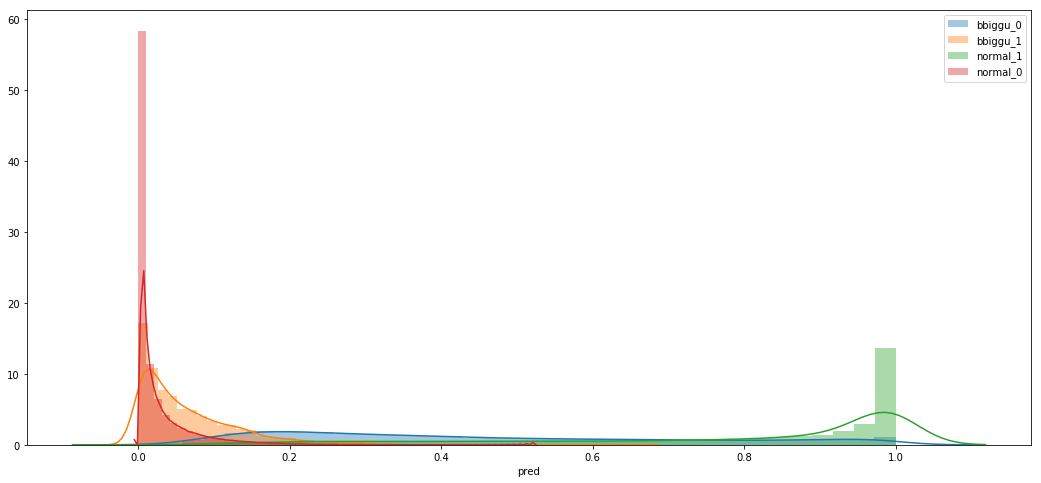

In [68]:
plt.figure(figsize=(18,8))
sns.distplot(bbiggu_0.pred, label='bbiggu_0')
sns.distplot(bbiggu_1.pred, label='bbiggu_1')
sns.distplot(normal_1.pred, label='normal_1')
sns.distplot(normal_0.pred, label='normal_0')
plt.legend()

In [82]:
roc_auc_score(oof.target, oof.pred.rank() * train.pred.rank())

0.9230391661784649

In [79]:
roc_auc_score(train.target, oof.pred)

0.9227387044712247

In [ ]:
bbiggu_0[['target', 'pred']]

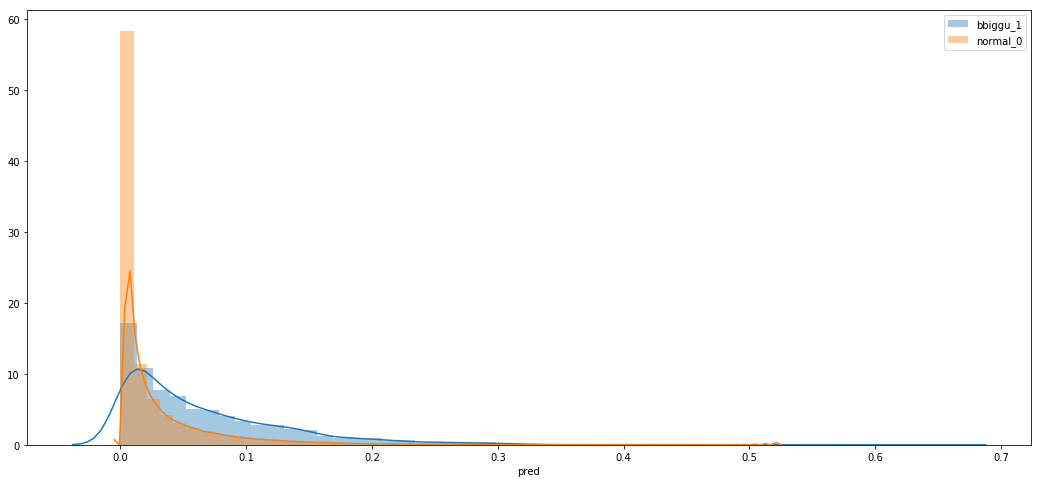

In [43]:
plt.figure(figsize=(18,8))
sns.distplot(bbiggu_1.pred, label='bbiggu_1')
sns.distplot(normal_0.pred, label='normal_0')
plt.legend()

In [54]:
new_data = bbiggu_0.append(bbiggu_1).append(normal_0).append(normal_1).append(test).sort_index()

In [83]:
new_data.pred = new_data.pred.rank()

In [84]:
train = new_data[~new_data.target.isna()]
test = new_data[new_data.target.isna()]

In [85]:
target = train.target

In [86]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.335,
    'boost_from_average': False,
    'boost': 'gbdt',
    'feature_fraction_seed': 47,
    'feature_fraction': 0.041,
    'learning_rate': 0.01,
    'max_depth': -1,
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 2,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': 1,
    'num_threads': 8
}

In [87]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))
feature_importance = pd.DataFrame()

train_columns = [c for c in train.columns if c not in ['ID_code', 'target']]

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, target.values)):    
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][train_columns], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx][train_columns], label=target.iloc[val_idx])

    num_round = 500000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=5000, early_stopping_rounds = 3500)
    oof_lgb[val_idx] = clf.predict(train.iloc[val_idx][train_columns], num_iteration=clf.best_iteration)
    predictions_lgb += clf.predict(test[train_columns], num_iteration=clf.best_iteration) / folds.n_splits

    fold_importance = pd.DataFrame()
    fold_importance["Feature"] = train_columns
    fold_importance["importance"] = clf.feature_importance()
    fold_importance["fold"] = fold_ + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
    print("CV score: {:<8.5f}".format(roc_auc_score(target.values[val_idx], oof_lgb[val_idx])))
            
print("CV score: {:<8.5f}".format(roc_auc_score(target.values, oof_lgb)))

fold n°0
Training until validation scores don't improve for 3500 rounds.
[5000]	training's auc: 0.921393	valid_1's auc: 0.915594
[10000]	training's auc: 0.926334	valid_1's auc: 0.919119
[15000]	training's auc: 0.928845	valid_1's auc: 0.919836
[20000]	training's auc: 0.930793	valid_1's auc: 0.920003
Early stopping, best iteration is:
[18092]	training's auc: 0.930093	valid_1's auc: 0.92002
CV score: 0.92002 
fold n°1
Training until validation scores don't improve for 3500 rounds.
[5000]	training's auc: 0.920889	valid_1's auc: 0.917877
[10000]	training's auc: 0.926035	valid_1's auc: 0.920079
[15000]	training's auc: 0.928618	valid_1's auc: 0.920609
[20000]	training's auc: 0.930649	valid_1's auc: 0.920486
Early stopping, best iteration is:
[17939]	training's auc: 0.929892	valid_1's auc: 0.920625
CV score: 0.92063 
fold n°2
Training until validation scores don't improve for 3500 rounds.
[5000]	training's auc: 0.919614	valid_1's auc: 0.922272
[10000]	training's auc: 0.924563	valid_1's auc: 0.

# 삐꾸 분포 실험

# Post Processing

In [533]:
oof_test = oof[oof.ID_code.isin(normal_0_val.ID_code.append(bbiggu_1_id_code))].sort_index()

In [534]:
normal_0_val_df = normal_0_val[['ID_code']]
bbiggu_1_df = bbiggu_1[['ID_code']]

In [535]:
normal_0_val_df['new_pred'] = clf_new.predict(normal_0_val[train_columns], num_iteration=clf_new.best_iteration)
bbiggu_1_df['new_pred'] = clf_new.predict(bbiggu_1[train_columns], num_iteration=clf_new.best_iteration)

temp = normal_0_val_df.append(bbiggu_1_df).sort_index()

In [536]:
oof_test['new_pred'] = temp.new_pred

In [537]:
oof_test[['pred', 'new_pred']].corr()

,pred,new_pred
pred,1.000000,0.863122
new_pred,0.863122,1.000000


In [538]:
roc_auc_score(oof_test.target, oof_test.pred), roc_auc_score(oof_test.target, oof_test.pred * oof_test.new_pred), roc_auc_score(oof_test.target, oof_test.pred * oof_test.new_pred.rank())

(0.7820198692641739, 0.7860639714065095, 0.7853244720327238)

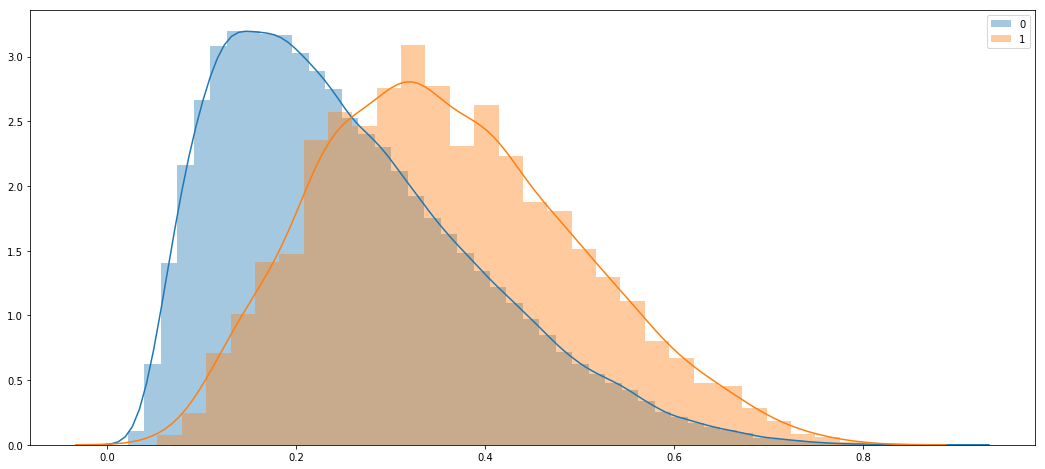

In [246]:
iteration = 8000
plt.figure(figsize=(18,8))
sns.distplot(clf_new.predict(normal_0_val[train_columns], num_iteration=iteration), label='0')
sns.distplot(clf_new.predict(bbiggu_1[train_columns], num_iteration=iteration), label='1')
plt.legend()

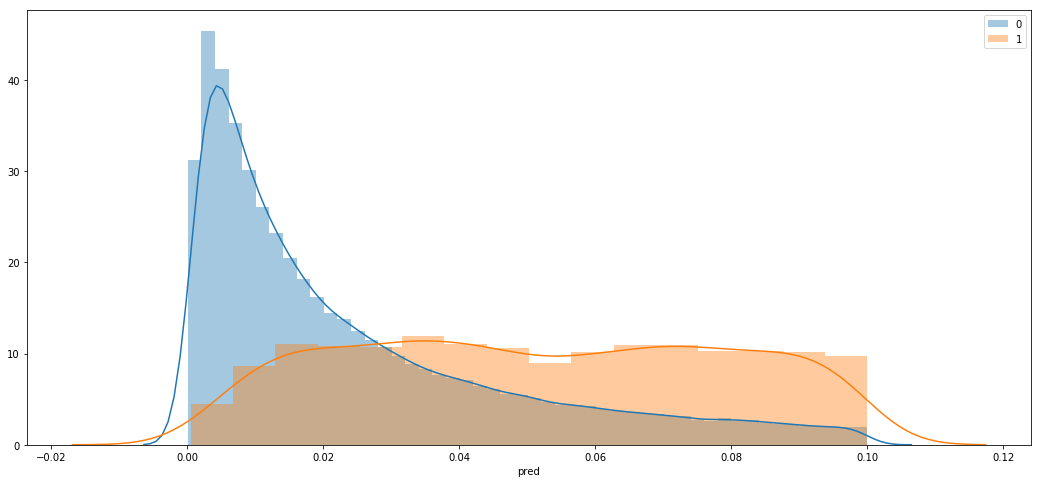

In [341]:
plt.figure(figsize=(18,8))
sns.distplot(oof_test[oof_test.target == 0].pred, label='0')
sns.distplot(oof_test[oof_test.target == 1].pred, label='1')
plt.legend()

In [366]:
t1 = oof_test[oof_test.pred < 0.028]
t2 = oof_test[oof_test.pred > 0.028]

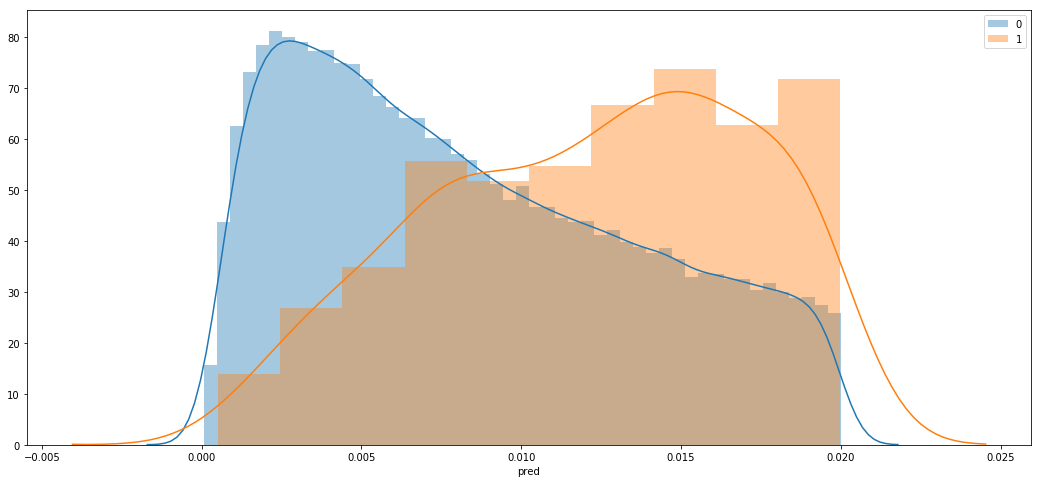

In [354]:
plt.figure(figsize=(18,8))
sns.distplot(t1[t1.target == 0].pred, label='0')
sns.distplot(t1[t1.target == 1].pred, label='1')
plt.legend()

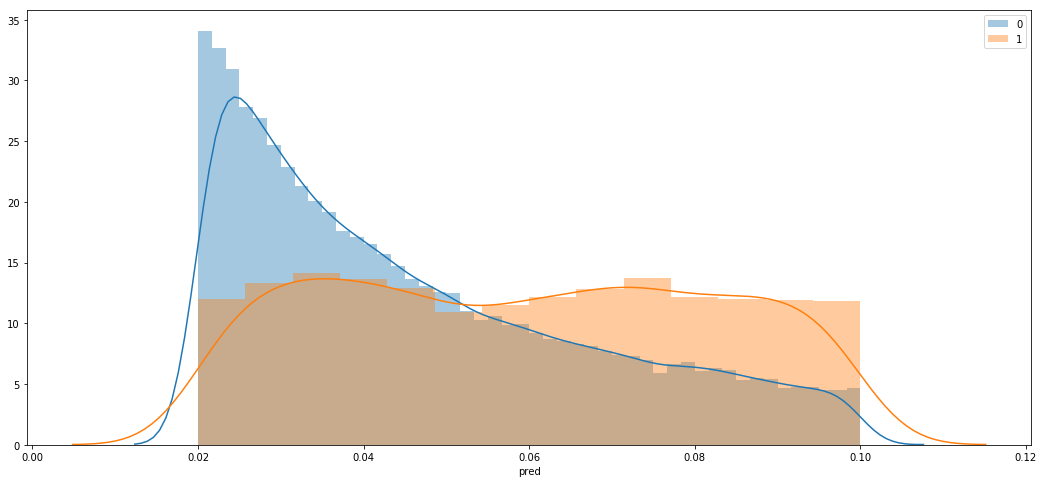

In [355]:
plt.figure(figsize=(18,8))
sns.distplot(t2[t2.target == 0].pred, label='0')
sns.distplot(t2[t2.target == 1].pred, label='1')
plt.legend()

In [379]:
roc_auc_score(t1.target, t1.pred), roc_auc_score(t1.target, t1.pred * (t1.new_pred + 1)), roc_auc_score(t1.target, t1.pred * t1.new_pred.rank())

(0.7043563876684081, 0.7064446428601455, 0.7101016291946844)

In [368]:
roc_auc_score(t2.target, t2.pred), roc_auc_score(t2.target, t2.pred * t2.new_pred), roc_auc_score(t2.target, t2.pred * t2.new_pred.rank())

(0.6334818636606555, 0.6327271828174961, 0.6320155186092915)

In [429]:
t1['final'] = t1.pred * t1.new_pred.rank()
t1['final'] = (t1['final'] - t1['final'].min()) * 0.0325 / (t1['final'].max() -t1['final'].min())
t2['final'] = t2.pred
t3 = t1.append(t2).sort_index()

In [430]:
roc_auc_score(t3.target, t3.final)

0.7831307560763037

In [266]:
t1[t1.target == 1][['pred', 'new_pred']].corr()

,pred,new_pred
pred,1.000000,0.682368
new_pred,0.682368,1.000000


In [267]:
t1[t1.target == 0][['pred', 'new_pred']].corr()

,pred,new_pred
pred,1.000000,0.791083
new_pred,0.791083,1.000000


In [270]:
t2[t2.target == 1][['pred', 'new_pred']].corr()

,pred,new_pred
pred,1.000000,0.634485
new_pred,0.634485,1.000000


In [271]:
t2[t2.target == 0][['pred', 'new_pred']].corr()

,pred,new_pred
pred,1.0000,0.6403
new_pred,0.6403,1.0000


In [555]:
unchange = oof[(~oof.ID_code.isin(normal_0_tr.ID_code))]
unchange = unchange[(~unchange.ID_code.isin(oof_test.ID_code))]
unchange['post_pred'] = unchange['pred']
unchange['post_pred_rank'] = unchange['pred'] + 100000

change = oof_test.copy()
change['post_pred'] = change.pred * change.new_pred
change['post_pred_rank'] = change.pred * change.new_pred.rank()
temp = change.append(unchange).sort_index()

In [556]:
roc_auc_score(temp.target, temp.pred), roc_auc_score(temp.target, temp.post_pred), roc_auc_score(temp.target, temp.post_pred_rank)

(0.8968258842428717, 0.8973038217360192, 0.8972164266939425)

# sub

In [579]:
te_temp = test[['ID_code']]
te_temp['pred'] = predictions_lgb # 922짜리

In [580]:
temp = te_temp[te_temp.pred < 0.1].copy()
temp_data = data[data.ID_code.isin(temp.ID_code)]

In [581]:
temp['new_pred'] = clf_new.predict(temp_data[train_columns], num_iteration=clf_new.best_iteration)

In [582]:
temp['post_pred'] = temp['pred'] * temp['new_pred']

In [583]:
te_temp.loc[te_temp.ID_code.isin(temp.ID_code), 'pred'] = temp['post_pred']

In [584]:
te_temp.columns = ['ID_code', 'target']

In [37]:
te_temp = pd.read_csv('./data_temp/test_92274.csv')

In [38]:
sub = pd.read_csv('./data/sample_submission.csv')
# unchange = sub[~sub.ID_code.isin(te_temp.ID_code)]
# sub = te_temp[['ID_code', 'target']].append(unchange).sort_index()

In [42]:
te_temp

,ID_code,target
0,test_7,0.066608
1,test_17,0.018760
2,test_18,0.054083
3,test_21,0.040384
4,test_24,0.007588
5,test_29,0.016276
6,test_48,0.004924
7,test_63,0.037557
8,test_68,0.004899
9,test_69,0.000781


In [39]:
sub.loc[sub.ID_code.isin(te_temp.ID_code), 'target'] = te_temp['target'].values

In [41]:
sub.to_csv('./data_temp/92274.csv',index=False)

In [36]:
pd.read_csv('./data_temp/92274.csv')

,ID_code,target
0,test_0,0.000000
1,test_1,0.000000
2,test_2,0.000000
3,test_3,0.040384
4,test_4,0.000000
5,test_5,0.000000
6,test_6,0.000000
7,test_7,0.037557
8,test_8,0.000000
9,test_9,0.000000


In [601]:
te_temp.sort_index()

,ID_code,target,pred
3,test_3,1.161657e-01,0.116166
7,test_7,7.116388e-03,0.066608
11,test_11,1.809062e-03,0.042273
15,test_15,8.876063e-04,0.033467
16,test_16,4.116086e-01,0.411609
17,test_17,3.030695e-04,0.018760
18,test_18,1.087449e-02,0.054083
20,test_20,5.049735e-01,0.504973
21,test_21,4.854969e-03,0.040384
22,test_22,1.479836e-04,0.012507


In [599]:
sub

,ID_code,target
0,test_0,0.000000e+00
1,test_1,0.000000e+00
2,test_2,0.000000e+00
3,test_3,1.161657e-01
4,test_4,0.000000e+00
5,test_5,0.000000e+00
6,test_6,0.000000e+00
7,test_7,7.116388e-03
8,test_8,0.000000e+00
9,test_9,0.000000e+00


In [586]:
te_temp['pred'] = predictions_lgb

In [592]:
sub.to_csv('./data/lgb_cv_922_post.csv', index=False)

In [326]:
te_900 = pd.read_csv('./data/sub_cv_900.csv').rename(columns={'target':'900'})
te_901 = pd.read_csv('./data/sub_cv_901.csv').rename(columns={'target':'901'})
te_902 = pd.read_csv('./data/sub_cv_902.csv').rename(columns={'target':'902'})
te_912 = pd.read_csv('./data/sub_cv_912.csv').rename(columns={'target':'912'})
te_915 = pd.read_csv('./data/sub_cv_915.csv').rename(columns={'target':'915'})
# te_921 = pd.read_csv('./data/sub_cv_921.csv').rename(columns={'target':'921'})
te_922 = pd.read_csv('./data/sub_cv_922.csv').rename(columns={'target':'922'})
te_923_base = pd.read_csv('./data/sub_cv_923_base.csv').rename(columns={'target':'base'})
te_923_best = pd.read_csv('./data/sub_cv_923_best_1.csv').rename(columns={'target':'best'})
te_923_conaround = pd.read_csv('./data/sub_cv_923_conaround.csv').rename(columns={'target':'around'})
te_923_concategory = pd.read_csv('./data/sub_cv_923_concategory.csv').rename(columns={'target':'category'})
te_923_new_aug = pd.read_csv('./data/sub_cv_923_new_aug.csv').rename(columns={'target':'new_Aug'})
te_923_rank_median = pd.read_csv('./data/sub_cv_923_rank_median.csv').rename(columns={'target':'rank_med'})
te_923_staking = pd.read_csv('./data/sub_cv_923_stacking.csv').rename(columns={'target':'stacking'})
te_923_xgb_aug = pd.read_csv('./data/sub_cv_923_xgb_aug.csv').rename(columns={'target':'xgb'})
te_924 = pd.read_csv('./data/sub_cv_924.csv').rename(columns={'target':'924'})
te_924.ID_code = test_real.sort_index().ID_code.values
te_925 = pd.read_csv('./data/sub_cv_925.csv').rename(columns={'0':'925'})
te_925_yh = pd.read_csv('./data/sub_cv_925_yh.csv').rename(columns={'0':'925_yh'})

In [327]:
temp = te_900.merge(te_901, on='ID_code')
temp = temp.merge(te_902, on='ID_code')
temp = temp.merge(te_912, on='ID_code')
temp = temp.merge(te_915, on='ID_code')
# temp = temp.merge(te_921, on='ID_code')
temp = temp.merge(te_922, on='ID_code')
temp = temp.merge(te_923_base, on='ID_code')
temp = temp.merge(te_923_best, on='ID_code')
temp = temp.merge(te_923_conaround, on='ID_code')
temp = temp.merge(te_923_concategory, on='ID_code')
temp = temp.merge(te_923_new_aug, on='ID_code')
temp = temp.merge(te_923_rank_median, on='ID_code')
temp = temp.merge(te_923_staking, on='ID_code')
temp = temp.merge(te_923_xgb_aug, on='ID_code')
temp = temp.merge(te_924, on='ID_code', how='left')
temp = temp.merge(te_925, on='ID_code', how='left')
temp = temp.merge(te_925_yh, on='ID_code', how='left')

In [328]:
temp = temp[temp.ID_code.isin(test_real.ID_code)]

In [332]:
for col in temp.columns:
    if col == 'ID_code':
        continue
    
    temp[col] = temp[col].rank()

In [333]:
temp.corr()

,900,901,902,912,915,922,base,best,around,category,new_Aug,rank_med,stacking,xgb,924,925,925_yh
900,1.000000,0.997714,0.998234,0.979190,0.939922,0.926396,0.910923,0.903550,0.901150,0.903471,0.903397,0.912718,0.909566,0.905286,0.917009,0.901971,0.916701
901,0.997714,1.000000,0.996496,0.978343,0.938540,0.928181,0.912111,0.905122,0.902270,0.904537,0.905314,0.914145,0.910951,0.906950,0.919006,0.903873,0.918673
902,0.998234,0.996496,1.000000,0.981148,0.944666,0.931104,0.916523,0.909019,0.907065,0.909360,0.908747,0.918206,0.914808,0.910394,0.922055,0.907321,0.921739
912,0.979190,0.978343,0.981148,1.000000,0.975589,0.969828,0.954733,0.949977,0.948067,0.950012,0.949226,0.955939,0.951658,0.951047,0.958416,0.947942,0.958133
915,0.939922,0.938540,0.944666,0.975589,1.000000,0.991727,0.978784,0.976433,0.976351,0.977629,0.975457,0.979196,0.974735,0.975210,0.978607,0.974465,0.978495
922,0.926396,0.928181,0.931104,0.969828,0.991727,1.000000,0.989431,0.988875,0.988061,0.989000,0.988287,0.989915,0.984684,0.988341,0.989824,0.987381,0.989750
base,0.910923,0.912111,0.916523,0.954733,0.978784,0.989431,1.000000,0.997996,0.998411,0.998634,0.997133,0.999727,0.992126,0.996967,0.996213,0.996307,0.996189
best,0.903550,0.905122,0.909019,0.949977,0.976433,0.988875,0.997996,1.000000,0.999023,0.998689,0.999102,0.998220,0.992009,0.997903,0.997135,0.998295,0.997121
around,0.901150,0.902270,0.907065,0.948067,0.976351,0.988061,0.998411,0.999023,1.000000,0.999299,0.998262,0.998409,0.991647,0.996586,0.996001,0.997451,0.995985
category,0.903471,0.904537,0.909360,0.950012,0.977629,0.989000,0.998634,0.998689,0.999299,1.000000,0.997909,0.998630,0.991896,0.996608,0.996017,0.997093,0.996004


In [334]:
temp[temp.ID_code.isin(test_pb.ID_code)].corr()

,900,901,902,912,915,922,base,best,around,category,new_Aug,rank_med,stacking,xgb,924,925,925_yh
900,1.000000,0.997709,0.998245,0.979185,0.940310,0.926921,0.911547,0.904267,0.901884,0.904155,0.904184,0.913390,0.910109,0.905889,0.917702,0.902771,0.917333
901,0.997709,1.000000,0.996496,0.978359,0.938867,0.928667,0.912634,0.905755,0.902914,0.905124,0.906012,0.914714,0.911379,0.907456,0.919653,0.904595,0.919268
902,0.998245,0.996496,1.000000,0.981185,0.945026,0.931600,0.917062,0.909647,0.907702,0.909936,0.909441,0.918791,0.915508,0.910917,0.922658,0.908034,0.922291
912,0.979185,0.978359,0.981185,1.000000,0.975663,0.969993,0.954973,0.950259,0.948329,0.950271,0.949536,0.956209,0.954142,0.951255,0.958668,0.948252,0.958345
915,0.940310,0.938867,0.945026,0.975663,1.000000,0.991705,0.978855,0.976445,0.976372,0.977682,0.975479,0.979274,0.978838,0.975203,0.978593,0.974501,0.978447
922,0.926921,0.928667,0.931600,0.969993,0.991705,1.000000,0.989403,0.988837,0.988023,0.988983,0.988240,0.989899,0.989455,0.988308,0.989803,0.987347,0.989703
base,0.911547,0.912634,0.917062,0.954973,0.978855,0.989403,1.000000,0.997990,0.998419,0.998641,0.997139,0.999725,0.997696,0.996925,0.996202,0.996327,0.996162
best,0.904267,0.905755,0.909647,0.950259,0.976445,0.988837,0.997990,1.000000,0.999019,0.998671,0.999102,0.998213,0.997805,0.997914,0.997132,0.998308,0.997107
around,0.901884,0.902914,0.907702,0.948329,0.976372,0.988023,0.998419,0.999019,1.000000,0.999288,0.998262,0.998413,0.997551,0.996582,0.995995,0.997467,0.995967
category,0.904155,0.905124,0.909936,0.950271,0.977682,0.988983,0.998641,0.998671,0.999288,1.000000,0.997894,0.998632,0.997704,0.996588,0.995994,0.997097,0.995967


In [335]:
temp[temp.ID_code.isin(test_pv.ID_code)].corr()

,900,901,902,912,915,922,base,best,around,category,new_Aug,rank_med,stacking,xgb,924,925,925_yh
900,1.000000,0.997719,0.998223,0.979195,0.939536,0.925875,0.910303,0.902835,0.900420,0.902790,0.902613,0.912049,0.917861,0.904686,0.916319,0.901174,0.916072
901,0.997719,1.000000,0.996497,0.978328,0.938215,0.927699,0.911590,0.904492,0.901628,0.903953,0.904618,0.913577,0.919426,0.906446,0.918362,0.903155,0.918082
902,0.998223,0.996497,1.000000,0.981111,0.944307,0.930610,0.915986,0.908394,0.906431,0.908787,0.908055,0.917623,0.923005,0.909873,0.921454,0.906612,0.921190
912,0.979195,0.978328,0.981111,1.000000,0.975517,0.969664,0.954494,0.949695,0.947807,0.949753,0.948917,0.955672,0.958479,0.950840,0.958166,0.947633,0.957923
915,0.939536,0.938215,0.944307,0.975517,1.000000,0.991749,0.978713,0.976422,0.976329,0.977577,0.975435,0.979118,0.980102,0.975218,0.978621,0.974429,0.978543
922,0.925875,0.927699,0.930610,0.969664,0.991749,1.000000,0.989459,0.988913,0.988100,0.989018,0.988334,0.989932,0.989540,0.988375,0.989846,0.987414,0.989797
base,0.910303,0.911590,0.915986,0.954494,0.978713,0.989459,1.000000,0.998002,0.998404,0.998626,0.997127,0.999729,0.996095,0.997010,0.996224,0.996287,0.996217
best,0.902835,0.904492,0.908394,0.949695,0.976422,0.988913,0.998002,1.000000,0.999028,0.998707,0.999102,0.998228,0.995752,0.997892,0.997139,0.998282,0.997135
around,0.900420,0.901628,0.906431,0.947807,0.976329,0.988100,0.998404,0.999028,1.000000,0.999310,0.998261,0.998406,0.995294,0.996589,0.996007,0.997436,0.996004
category,0.902790,0.903953,0.908787,0.949753,0.977577,0.989018,0.998626,0.998707,0.999310,1.000000,0.997923,0.998628,0.995600,0.996628,0.996040,0.997089,0.996040


In [147]:
d1 = pd.read_csv('./data_temp/bbiggu_1.csv')

In [148]:
d2 = pd.read_csv('./data_temp/new_bbiggu.csv')

In [149]:
d3 = pd.read_csv('./data_temp/new_bbiggu_magic2.csv')

In [151]:
dd = d2[['ID_code', 'target']]

In [152]:
dd['900'] = d1.pred
dd['911'] = d2.pred
dd['922'] = d3.pred

In [155]:
roc_auc_score(dd.target, dd['900']), roc_auc_score(dd.target, dd['911']), roc_auc_score(dd.target, dd['922'])

(0.9001888365158383, 0.9116527218981605, 0.9227387044712247)

In [258]:
oof = pd.read_csv('./data_temp/new_bbiggu_magic2.csv')

In [259]:
bbiggu_0_id_code = oof[(oof.target == 0) & (oof.pred > 0.1)].ID_code
bbiggu_1_id_code = oof[(oof.target == 1) & (oof.pred < 0.1)].ID_code
normal_0_id_code = oof[(oof.target == 0) & (oof.pred < 0.1)].ID_code
normal_1_id_code = oof[(oof.target == 1) & (oof.pred > 0.1)].ID_code

In [245]:
dd['900to911'] = dd['911'] - dd['900']
dd['900to922'] = dd['922'] - dd['900']
dd['911to922'] = dd['922'] - dd['911']

In [262]:
dd[dd.ID_code.isin(bbiggu_0_id_code)].sort_values('900to922')

,ID_code,target,900,911,922,900to911,900to922,911to922
98832,train_98832,0.0,0.799446,0.704062,0.253523,-0.095384,-0.545923,-0.450539
23447,train_23447,0.0,0.679734,0.496370,0.196839,-0.183364,-0.482896,-0.299531
61046,train_61046,0.0,0.855846,0.794542,0.381632,-0.061304,-0.474214,-0.412910
101938,train_101938,0.0,0.600080,0.315671,0.133872,-0.284409,-0.466208,-0.181799
10917,train_10917,0.0,0.625302,0.538072,0.166881,-0.087230,-0.458421,-0.371191
65563,train_65563,0.0,0.668810,0.457091,0.214240,-0.211718,-0.454569,-0.242851
35101,train_35101,0.0,0.613416,0.548364,0.160134,-0.065052,-0.453282,-0.388230
196295,train_196295,0.0,0.604342,0.463175,0.155225,-0.141166,-0.449117,-0.307950
151869,train_151869,0.0,0.604173,0.521128,0.159869,-0.083046,-0.444305,-0.361259
61664,train_61664,0.0,0.562487,0.422961,0.123006,-0.139526,-0.439481,-0.299955


In [252]:
a = d3.sort_values('pred')

In [255]:
a[a.pred < 0.85]

,ID_code,target,pred
87870,train_87870,0.0,0.000085
111325,train_111325,0.0,0.000104
101539,train_101539,0.0,0.000109
91272,train_91272,0.0,0.000111
79990,train_79990,0.0,0.000113
132257,train_132257,0.0,0.000113
35412,train_35412,0.0,0.000114
78799,train_78799,0.0,0.000131
89251,train_89251,0.0,0.000137
29075,train_29075,0.0,0.000137
